In [1]:
import torch
import torchtext
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device availble for runing:")
print(device)

Device availble for runing:
cpu


In [2]:
import pandas as pd
import numpy as np
import os
import shutil
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
import tensorflow as tf
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
#Loading the audio
def load_audio_file(file_path):
  input_length = 535
  data = librosa.core.load(file_path)[0]
  if len(data)>input_length:
    data = data[:input_length]
  else:
    data = np.pad(data, (0, max(0, input_length - len(data))), "constant")
  return data


In [4]:
paths=[]
labels=[]


for dirname, _, filenames in os.walk('/content/drive/MyDrive/EmoDB_Dataset'):
  for filename in filenames:
      path = os.path.dirname(dirname)
      paths.append(os.path.join(dirname, filename))
      label = filename[5:6]

      if label == 'N':
            #disgust
           label = 'Neutral'
      if label == 'W':
           #sadness
           label = 'Ärger'
      if label == 'L':
           #happiness
          label = 'Langeweile'
      if label == 'E':
           #anxity
            label = 'Ekel'
      if label == 'A':
            #boredom
           label = 'Angst'
      if label == 'F':
            #anger
            label = 'Freude'
      if label == 'T':
            #anger
            label = 'Trauer'
      labels.append(label)


print("Dataset is loaded")

Dataset is loaded


In [5]:
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,/content/drive/MyDrive/EmoDB_Dataset/03a04Nc.wav,Neutral
1,/content/drive/MyDrive/EmoDB_Dataset/03a02Fc.wav,Freude
2,/content/drive/MyDrive/EmoDB_Dataset/03a02Wb.wav,Ärger
3,/content/drive/MyDrive/EmoDB_Dataset/03a01Nc.wav,Neutral
4,/content/drive/MyDrive/EmoDB_Dataset/03a02Wc.wav,Ärger


In [6]:
df['label'].value_counts()

label
Ärger         127
Langeweile     81
Neutral        79
Freude         71
Angst          69
Trauer         62
Ekel           46
Name: count, dtype: int64

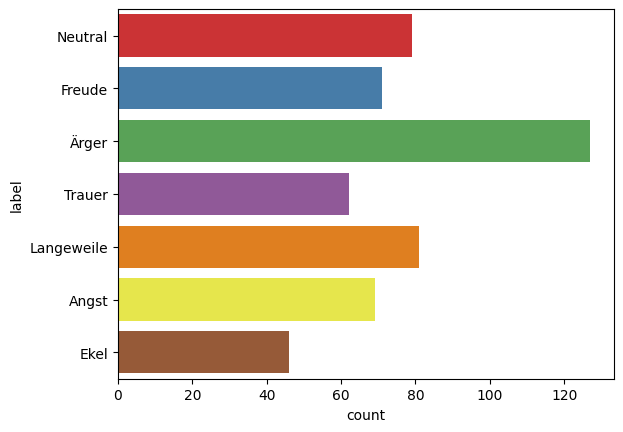

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing the 'label' column
sns.countplot(data=df, y='label', palette='Set1')
plt.show()

In [ ]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

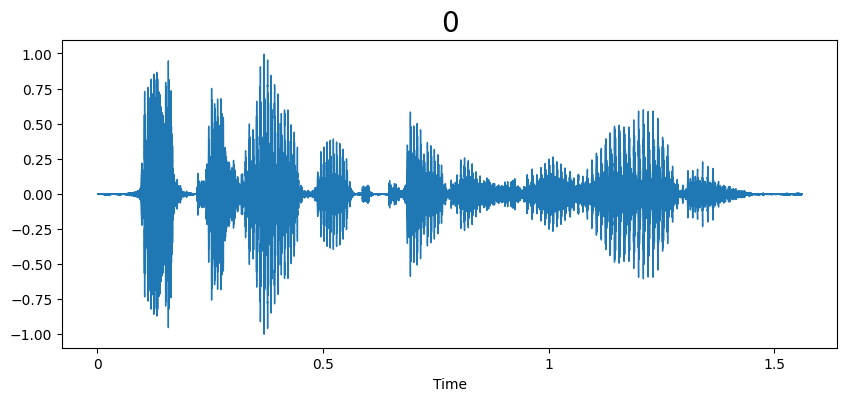

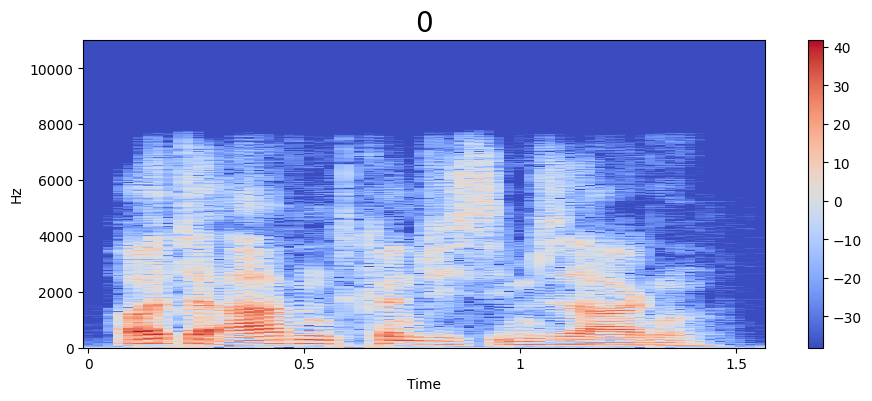

In [ ]:
emotion = 0
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

In [ ]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

In [ ]:
extract_mfcc(df['speech'][0])

array([-2.6623233e+02,  1.4108714e+02, -2.8336123e+01,  5.8924068e+01,
       -1.2522770e+01,  1.8960411e+01, -1.1402384e+01,  7.2823267e+00,
       -1.2426398e+01, -3.5440960e+00,  1.3309047e+00, -8.2763395e+00,
        4.1262093e+00, -9.6710291e+00,  9.0884171e+00, -1.4934006e+00,
       -5.9034187e-01, -4.4966960e+00,  1.7627999e+00, -1.4397067e+00,
       -3.1797299e+00,  2.4016500e+00, -5.5629401e+00,  1.7393342e-01,
       -2.5573177e+00,  2.3359224e-01, -4.2044258e+00,  1.3322746e+00,
       -3.0907421e+00, -2.2449317e+00,  1.2653856e+00, -4.4307766e+00,
       -6.3282305e-01, -3.2602191e+00, -1.9118279e+00, -4.0693541e+00,
       -2.1822364e+00, -3.1013839e+00, -1.8185632e+00, -2.5200574e+00],
      dtype=float32)

In [ ]:
X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))

In [ ]:
X_mfcc

0      [-266.23233, 141.08714, -28.336123, 58.92407, ...
1      [-270.02908, 93.78522, -32.669037, 34.093903, ...
2      [-234.41504, 86.713234, -52.81957, 50.56059, -...
3      [-271.5491, 133.97523, -29.975306, 47.540462, ...
4      [-278.36145, 97.51109, -64.39289, 35.982758, -...
                             ...                        
530    [-251.33835, 99.55501, -37.320415, 72.94557, -...
531    [-248.16628, 64.43315, -80.10315, 61.991024, -...
532    [-287.3482, 45.413692, -79.45413, 52.74445, -3...
533    [-242.61118, 86.56665, -21.371408, 55.09278, -...
534    [-285.64136, 52.8432, -92.20018, 53.65221, -57...
Name: speech, Length: 535, dtype: object

In [ ]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(535, 40)

In [ ]:
X = np.expand_dims(X, -1)
X.shape

(535, 40, 1)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])

In [ ]:
y = y.toarray()

In [ ]:
y.shape

(535, 7)

In [ ]:
import tensorflow as tf
# import tensorflow.keras
from tensorflow import keras
from keras import optimizers
import numpy as np
import matplotlib.pyplot as plt
#from tensorflow.keras import optimizers
#from tensorflow.keras.optimizers import rmsprop_v2
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import LSTM,Masking,concatenate,AveragePooling1D, BatchNormalization

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(40,1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 7)                 4

In [ ]:
history = model.fit(X, y, validation_split=0.2, epochs=50, batch_size=64)

Epoch 1/50
7/7 [==============================] - 8s 417ms/step - loss: 1.8766 - accuracy: 0.2757 - val_loss: 1.8643 - val_accuracy: 0.3271
Epoch 2/50
7/7 [==============================] - 2s 240ms/step - loss: 1.7184 - accuracy: 0.3318 - val_loss: 1.6940 - val_accuracy: 0.3364
Epoch 3/50
7/7 [==============================] - 1s 158ms/step - loss: 1.5829 - accuracy: 0.3621 - val_loss: 1.6592 - val_accuracy: 0.3738
Epoch 4/50
7/7 [==============================] - 1s 154ms/step - loss: 1.5097 - accuracy: 0.4065 - val_loss: 1.5718 - val_accuracy: 0.4019
Epoch 5/50
7/7 [==============================] - 1s 158ms/step - loss: 1.4049 - accuracy: 0.4463 - val_loss: 1.8007 - val_accuracy: 0.3084
Epoch 6/50
7/7 [==============================] - 1s 149ms/step - loss: 1.3088 - accuracy: 0.4416 - val_loss: 1.5782 - val_accuracy: 0.3551
Epoch 7/50
7/7 [==============================] - 1s 148ms/step - loss: 1.2467 - accuracy: 0.4860 - val_loss: 1.9018 - val_accuracy: 0.3271
Epoch 8/50
7/7 [====

In [ ]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
print(X1_train.shape)
print(y1_train.shape)

(428, 40, 1)
(428, 7)


In [ ]:
# Importing necessary libraries
from sklearn.model_selection import KFold
import numpy as np

# Initializing KFold
FOLDS = 5
kf = KFold(n_splits=FOLDS)

# Initializing a list to store accuracy values
test_accuracy_scores = []

# Iterating over folds
for i, (train, test) in enumerate(kf.split(X1_train, y1_train)):
    X_train_kf = X1_train[train]
    y_train_kf = y1_train[train]
    X_test_kf = X1_train[test]
    y_test_kf = y1_train[test]

    # Training the model
    history = model.fit(X_train_kf, y_train_kf,
                        batch_size=16,
                        epochs=30,
                        validation_data=(X_test_kf, y_test_kf))

    # Evaluating the model on test data
    test_loss, test_accuracy = model.evaluate(X1_test, y1_test)
    test_accuracy_scores.append(test_accuracy)

Epoch 1/30
22/22 [==============================] - 4s 191ms/step - loss: 1.1911 - accuracy: 0.5468 - val_loss: 1.5355 - val_accuracy: 0.4535
Epoch 2/30
22/22 [==============================] - 2s 111ms/step - loss: 1.2348 - accuracy: 0.5439 - val_loss: 1.5162 - val_accuracy: 0.5116
Epoch 3/30
22/22 [==============================] - 2s 81ms/step - loss: 1.3419 - accuracy: 0.4766 - val_loss: 1.1428 - val_accuracy: 0.5233
Epoch 4/30
22/22 [==============================] - 2s 78ms/step - loss: 1.2828 - accuracy: 0.4825 - val_loss: 1.4188 - val_accuracy: 0.4767
Epoch 5/30
22/22 [==============================] - 2s 79ms/step - loss: 1.2519 - accuracy: 0.4766 - val_loss: 1.3036 - val_accuracy: 0.5233
Epoch 6/30
22/22 [==============================] - 2s 90ms/step - loss: 1.1522 - accuracy: 0.5614 - val_loss: 1.2313 - val_accuracy: 0.5000
Epoch 7/30
22/22 [==============================] - 3s 129ms/step - loss: 1.1253 - accuracy: 0.5526 - val_loss: 1.2969 - val_accuracy: 0.5000
Epoch 8/30

In [ ]:
# Printing the mean accuracy over all folds
print("Mean accuracy of the trained model on the test data: {:.2f}%".format(np.mean(test_accuracy_scores) * 100))

Mean accuracy of the trained model on the test data: 57.94%


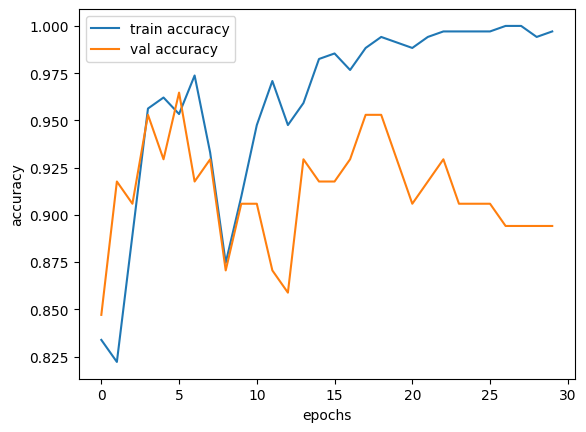

In [ ]:
#Accuracy of model
epochs = list(range(30))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

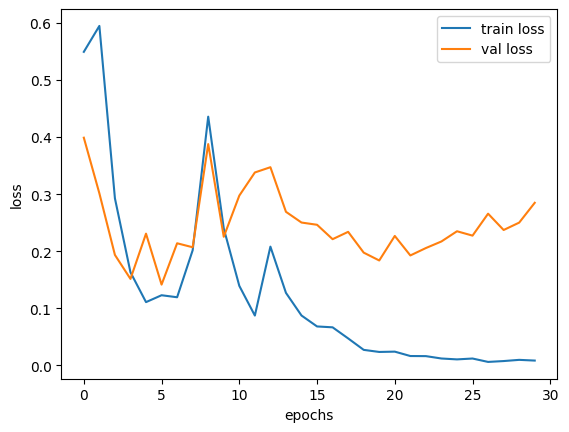

In [ ]:
#Loss of model
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
predictions = model.predict(X_test_kf)

class_names= np.argmax(predictions, axis=1)
new_Ytest = np.argmax(y_test_kf, axis=1)

report = classification_report(new_Ytest, class_names)
print(report)
# In[30]:
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt


from sklearn.metrics import confusion_matrix
predictions = model.predict(X_test_kf, steps=len(X_test_kf), verbose=0)
y_true=np.argmax(new_Ytest, axis=-1)

cm = confusion_matrix(new_Ytest, class_names)
print(cm)

3/3 [==============================] - 3s 70ms/step
              precision    recall  f1-score   support

           0       0.80      0.67      0.73        12
           1       0.96      0.96      0.96        25
           2       0.82      0.82      0.82        11
           3       1.00      1.00      1.00         7
           4       0.85      1.00      0.92        11
           5       0.89      0.80      0.84        10
           6       0.90      1.00      0.95         9

    accuracy                           0.89        85
   macro avg       0.89      0.89      0.89        85
weighted avg       0.89      0.89      0.89        85

[[ 8  0  2  0  1  0  1]
 [ 0 24  0  0  0  1  0]
 [ 2  0  9  0  0  0  0]
 [ 0  0  0  7  0  0  0]
 [ 0  0  0  0 11  0  0]
 [ 0  1  0  0  1  8  0]
 [ 0  0  0  0  0  0  9]]


In [ ]:
test_paths = []
for dirname, _, filenames in os.walk('/content/drive/MyDrive/EmoDB_Dataset'):
    for filename in filenames:
        test_path = os.path.dirname(dirname)
        test_paths.append(os.path.join(dirname, filename))

In [ ]:
# adding to dataframe
df_test = pd.DataFrame()
df_test['test_speech'] = test_paths
df_test.head()

,test_speech
0,/content/drive/MyDrive/EmoDB_Dataset/03a04Nc.wav
1,/content/drive/MyDrive/EmoDB_Dataset/03a02Fc.wav
2,/content/drive/MyDrive/EmoDB_Dataset/03a02Wb.wav
3,/content/drive/MyDrive/EmoDB_Dataset/03a01Nc.wav
4,/content/drive/MyDrive/EmoDB_Dataset/03a02Wc.wav


In [ ]:
#extracting feature
extract_mfcc(df_test['test_speech'][0])

array([-2.6623233e+02,  1.4108714e+02, -2.8336123e+01,  5.8924068e+01,
       -1.2522770e+01,  1.8960411e+01, -1.1402384e+01,  7.2823267e+00,
       -1.2426398e+01, -3.5440960e+00,  1.3309047e+00, -8.2763395e+00,
        4.1262093e+00, -9.6710291e+00,  9.0884171e+00, -1.4934006e+00,
       -5.9034187e-01, -4.4966960e+00,  1.7627999e+00, -1.4397067e+00,
       -3.1797299e+00,  2.4016500e+00, -5.5629401e+00,  1.7393342e-01,
       -2.5573177e+00,  2.3359224e-01, -4.2044258e+00,  1.3322746e+00,
       -3.0907421e+00, -2.2449317e+00,  1.2653856e+00, -4.4307766e+00,
       -6.3282305e-01, -3.2602191e+00, -1.9118279e+00, -4.0693541e+00,
       -2.1822364e+00, -3.1013839e+00, -1.8185632e+00, -2.5200574e+00],
      dtype=float32)

In [ ]:
X_mfcc_test = df_test['test_speech'].apply(lambda x_test: extract_mfcc(x_test))

In [ ]:
X_test = [x_test for x_test in X_mfcc_test]
X_test = np.array(X_test)
X_test.shape

(535, 40)

In [ ]:
X_test = np.expand_dims(X_test, -1)
X_test.shape

(535, 40, 1)

In [ ]:
#predicting test data result
predictions = model.predict(X_test, batch_size = 32, verbose = 0)

In [ ]:
for prediction in predictions:
    print(prediction)

[9.9718070e-01 1.7821968e-10 2.7969331e-03 9.4413454e-06 6.0807588e-06
 4.9308682e-09 6.9281450e-06]
[2.2299453e-08 9.9652141e-05 9.8643092e-08 2.2421475e-06 2.6704379e-08
 9.9989718e-01 7.5803825e-07]
[4.2675287e-04 3.2921824e-01 1.0963762e-02 5.3138193e-04 9.8248117e-04
 6.5633404e-01 1.5434636e-03]
[9.9839050e-01 1.5105558e-09 1.4981792e-03 5.1233448e-05 2.3813249e-05
 2.9983703e-08 3.6321431e-05]
[1.2789556e-07 7.2142678e-01 1.7508557e-04 2.1269356e-05 3.3167071e-05
 2.7833793e-01 5.6557728e-06]
[1.1522017e-06 1.9649806e-04 2.1469702e-06 4.1555659e-06 2.6909748e-07
 9.9979186e-01 4.0166115e-06]
[4.2260268e-01 1.9484777e-04 5.3814721e-01 1.1532403e-03 5.4864082e-03
 2.8603044e-04 3.2129519e-02]
[3.2789344e-03 2.0671527e-09 9.9672043e-01 4.6503574e-09 3.5134711e-08
 9.0310953e-11 7.3527127e-07]
[1.3527523e-01 5.1933450e-05 3.0318025e-02 1.4072309e-03 9.1105938e-04
 5.7214493e-04 8.3146435e-01]
[1.6525510e-04 4.8768343e-03 6.6472523e-05 8.0585086e-01 1.4521018e-01
 4.3751221e-02 7.920